In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def read_text_file(file_path):
    # Read the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract the column headers from the first line
    column_headers = lines[0].strip().split('\t')
    
    # Create a list to store the data
    data = []
    
    # Process each line in the text file (excluding the first line)
    for line in lines[1:]:
        # Split the line into columns using tabs as the delimiter
        columns = [int(i) for i in line.strip().split('\t')]

        # Append the columns to the data list
        data.append(columns)
    
    # Create a pandas dataframe from the data and set the column headers
    df = pd.DataFrame(data, columns=column_headers)
    
    return df


In [4]:
import numpy as np
from scipy.optimize import curve_fit
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def fit_gaussian(df):
    x = df.values[180:, 0] / 1000
    y = df.values[180:, 1]

    p0 = [np.max(y), np.mean(x), np.std(x)]  # Initial guess for the parameters

    # Fit the Gaussian curve to the data
    popt, pcov = curve_fit(gaussian, x, y, p0=p0)
    print('std is %.3f' %popt[2])
    print(popt[1])
    # Extract the FWHM from the standard deviation
    fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]

    # Plot the data and the fitted curve
    plt.plot(x, y, label='Data')
    plt.plot(x, gaussian(x, *popt), label='Gaussian Fit')
    plt.xlabel('Time (ns)')
    plt.ylabel('Counts per bin (100ps)')
    plt.legend()

    # Add the FWHM to the legend
    plt.legend(['Laser on Silicon', f'Gaussian Fit (FWHM: {fwhm*-1:.2f} ns)'])

    plt.show()


std is -0.449
20.489298825088362


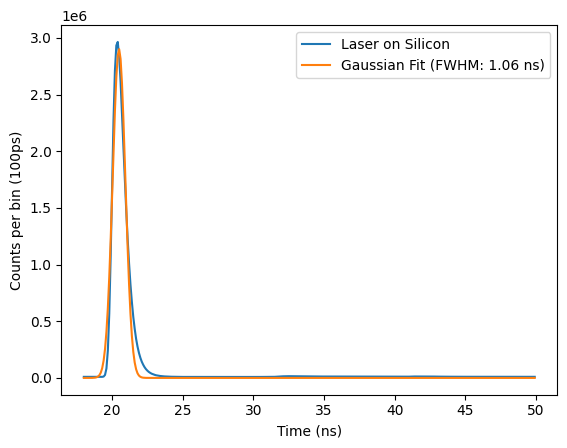

In [5]:
df = read_text_file('2024_02_15/laser_si.txt')
fit_gaussian(df) # 1.06 ns is FWHM of gaussian laser 

In [6]:
# reads in multiple files and sums the counts per bin across files
def read_multiple_text_files(file_paths):
    a = []
    b = []
    l = len(file_paths)
    # Process each file in the list 
    c = False
    for file_path in file_paths:
        d = read_text_file(file_path)
        if c == False:
            a = d.values[180:, 0]/1000
            b = d.values[180:, 1]
            c = True
        else:
            b += d.values[180:, 1]
    return a,b,l



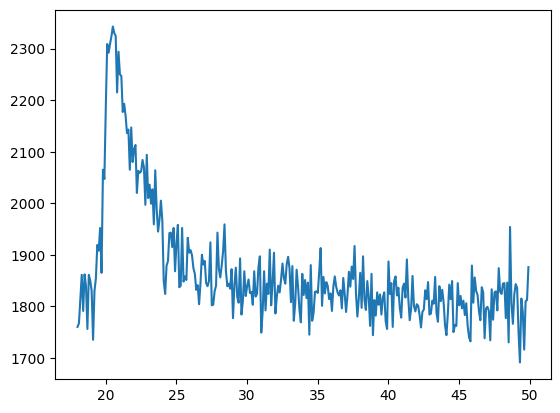

In [7]:
# for off sample 
times, cts, num_files = read_multiple_text_files(['2024_02_16/undoped_sio2/offsample1.txt', '2024_02_16/undoped_sio2/offsample2.txt', '2024_02_16/undoped_sio2/offsample3.txt'])
plt.plot(times, cts) # 30 min integration time 

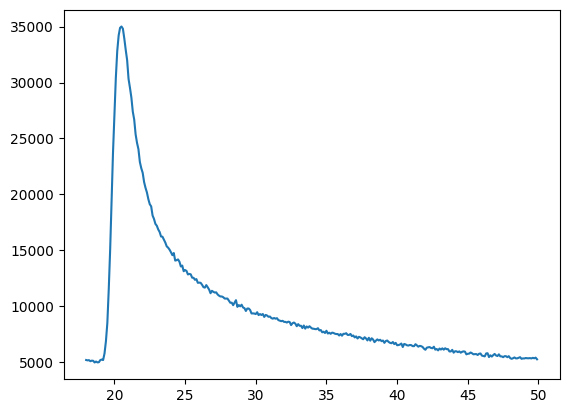

In [8]:
dot1 = ['2024_02_16/undoped_sio2/dot1/Histogram_2024-02-16_164853.txt', '2024_02_16/undoped_sio2/dot1/Histogram_2024-02-16_170058.txt', '2024_02_16/undoped_sio2/dot1/Histogram_2024-02-16_171116.txt']
dot2 = ['2024_02_16/undoped_sio2/dot2/Histogram_2024-02-16_182027.txt', '2024_02_16/undoped_sio2/dot2/Histogram_2024-02-16_205912.txt', '2024_02_16/undoped_sio2/dot2/Histogram_2024-02-16_211208.txt']
dot3 = ['2024_02_16/undoped_sio2/dot3/Histogram_2024-02-16_212316.txt', '2024_02_16/undoped_sio2/dot3/Histogram_2024-02-16_213333.txt','2024_02_16/undoped_sio2/dot3/Histogram_2024-02-16_214354.txt']
times_dot, cts_dot, num_files_dot = read_multiple_text_files(dot3)
plt.plot(times_dot, cts_dot) # 30 min integration time 

[ 1.01565599  0.1080628   1.2529816   0.46319865 19.98064637]


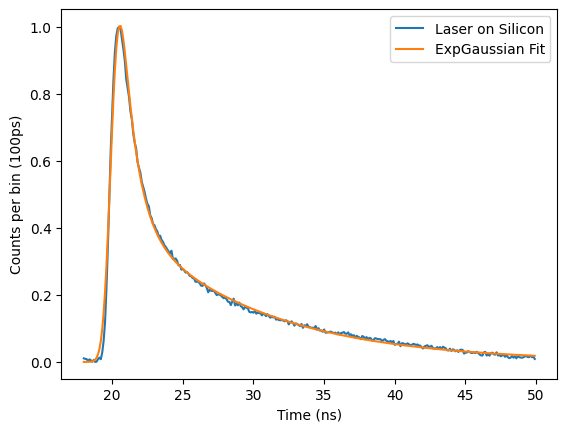

In [9]:
true_cts = cts_dot - cts # get rid of wierd bkg on sio2
true_cts = true_cts - min(true_cts) # normalize counts
true_cts = true_cts/max(true_cts) # normalize counts
#plt.plot(times_dot, true_cts) # 30 min integration time)
# scipt convolution for exponential and gaussian 
from scipy import special
# a is tau1, b is tau2, c is amplitude of tau1, d is amplitude of tau2, f is the time offset of gaussian
def expgaussian(x, a, b, c, d, f):
    return c/2*np.exp(a/2*(2*f+a*0.449**2-2*x))*special.erfc((f+a*0.449**2-x)/(np.sqrt(2)*0.449))+d/2*np.exp(b/2*(2*f+b*0.449**2-2*x))*special.erfc((f+b*0.449**2-x)/(np.sqrt(2)*0.449))
# https://arxiv.org/pdf/2201.03561.pdf
def fit_expgaussian(x,y):
    p0 = [0.1, 0.1, 1, 1, 20]  # Initial guess for the parameters
    boundsp0 = ((0,0, 0, 0, 10),(20,20,100,100, 30))
    popt, pcov = curve_fit(expgaussian, x, y, p0=p0, bounds = boundsp0, maxfev=10000, gtol = 1e-10)
    print(popt)
    # Plot the data and the fitted curve
    plt.plot(x, y, label='Data')
    plt.plot(x, expgaussian(x, *popt), label='ExpGaussian Fit')
    plt.xlabel('Time (ns)')
    plt.ylabel('Counts per bin (100ps)')
    plt.legend()

    # Add the FWHM to the legend
    plt.legend(['Data', 'BiExpGaussian Fit'])

    plt.show()
fit_expgaussian(times_dot, true_cts) # 1.06 ns is FWHM of gaussian laser